# **Binomial Option Pricing Model. A Technical and Didactic Guide**

This notebook presents a complete, hands-on implementation of the **Binomial Option Pricing Model** in Python.  Each section contains detailed theoretical explanations in Markdown + LaTeX, followed by executable Python code.  

The objective is to understand how to price both **European** and **American** options using discrete-time binomial trees, and to explore the impact of volatility, interest rate, and the number of time steps.

---
##  Mathematical Background
Under the risk-neutral measure, the expected return of the underlying equals the risk-free rate $r$.  Over a small time interval $\Delta t = \tfrac{T}{N}$ we define:

$$u = e^{\sigma \sqrt{\Delta t}}, \qquad d = e^{-\sigma \sqrt{\Delta t}},$$

and the **risk-neutral probability** of an up-move:

$$p = \frac{e^{r\Delta t} - d}{u - d}.$$

At maturity, the option value equals its payoff $V_N^j = f(S_N^j)$.  Moving backward through the tree we compute the discounted expected value:

$$V_i^j = e^{-r\Delta t}\,[pV_{i+1}^{j+1} + (1-p)V_{i+1}^j].$$

For an American option we take the maximum between continuation and immediate exercise:

$$V_i^j = \max\bigl(f(S_i^j),\; e^{-r\Delta t}[pV_{i+1}^{j+1}+(1-p)V_{i+1}^j]\bigr).$$

## **Section 1. Importing Required Libraries**

We start by importing the fundamental Python libraries used throughout this notebook.

- **math**: mathematical constants and elementary functions.
- **numpy**: vectorized numerical computation.
- **pandas**: data handling and time-series manipulation.
- **yfinance**: downloading historical price data from Yahoo Finance.
- **matplotlib**: visualization and tree plotting.
- **datetime**: date arithmetic.


In [1]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import display, Math


## **Section 2. Historical Data Retrieval**

This function retrieves adjusted historical prices from Yahoo Finance.  The parameter `lookback_years` defines how many years of data are used for volatility estimation.

In [2]:
def get_historical_data(ticker, end_date, lookback_years=7):
    """
    Retrieves historical price data from Yahoo Finance for a specified number of past years.
    The 'lookback_years' parameter can be an integer or a decimal (e.g., 2.5 for 2.5 years).
    """
    end_date = pd.to_datetime(end_date)
    # Calculation of days based on the number of years (365.25 days per year)
    days_offset = int(lookback_years * 365.25)
    start_date = end_date - pd.Timedelta(days=days_offset)

    df = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date, auto_adjust=True)
    return df


In [3]:
def to_scalar(x):
    """Μετατρέπει pandas Series / numpy array / scalar σε float για ασφαλές formatting."""
    import numpy as np
    import pandas as pd

    if isinstance(x, pd.Series):
        # πάρε την πρώτη (ή μοναδική) τιμή
        return float(x.iloc[0])
    if isinstance(x, (np.ndarray, list, tuple)):
        return float(np.array(x).ravel()[0])
    return float(x)


## **Section 3. Historical Volatility Calculation**

Volatility ($\sigma$) measures the standard deviation of returns.  For daily data we annualize by multiplying by $\sqrt{252}$, assuming 252 trading days per year.

## **Understanding Historical Volatility Calculation**

Volatility, denoted by $\sigma$, measures how much the price of a financial asset fluctuates over time.  
It is a key input in all option pricing models — higher volatility increases the probability that the option will end up in the money, thus increasing its price.

---

### **1️⃣ Step 1 – Compute Log Returns**
We first compute the **daily (or monthly) returns** of the asset:
$$
R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1
$$
where $P_t$ is the closing price at day $t$.

In the code, this is implemented as:

`df['Returns'] = df['Close'].pct_change()`

---

### **2️⃣ Step 2 – Compute Standard Deviation**
The historical volatility is simply the **standard deviation** of these returns over the observed period:
$$
\sigma_{\text{daily}} = \text{stdev}(R_t)
$$

This daily volatility measures the average relative price variation from one trading day to the next.

---

### **3️⃣ Step 3 – Annualize the Volatility**
Since most financial models (like Black–Scholes and the Binomial model) use **annualized volatility**, we multiply the daily standard deviation by the square root of the number of trading periods in one year:

- For **daily data**, there are about 252 trading days per year:
  $$
  \sigma_{\text{annual}} = \sigma_{\text{daily}} \times \sqrt{252}
  $$
- For **monthly data**, with roughly 12 months per year:
  $$
  \sigma_{\text{annual}} = \sigma_{\text{monthly}} \times \sqrt{12}
  $$

---

### **4️⃣ Intuitive Explanation**

This formula comes from the statistical property of the standard deviation of independent returns:  
if daily returns are independent and identically distributed, then
$$
\text{Var}(\text{annual returns}) = 252 \times \text{Var}(\text{daily returns})
$$
and therefore,
$$
\sigma_{\text{annual}} = \sqrt{252} \times \sigma_{\text{daily}}
$$

---

### **5️⃣ Practical Notes**
- Using **adjusted prices** (`auto_adjust=True` in Yahoo Finance) ensures that splits and dividends are correctly accounted for.  
- The historical volatility represents **past variability**, not necessarily the future one — but it serves as a reasonable estimate for the Binomial model.  
- You can experiment with different lookback periods (e.g., 1 year vs. 7 years) to see how volatility evolves over time.


In [4]:
def calculate_volatility(df, period='daily'):
    if period == 'daily':
        df['Returns'] = df['Close'].pct_change()
        volatility = df['Returns'].std() * math.sqrt(252)
    elif period == 'monthly':
        df_monthly = df['Close'].resample('M').last().pct_change()
        volatility = df_monthly.std() * math.sqrt(12)
    else:
        raise ValueError("Unsupported period. Use 'daily' or 'monthly'.")
    return volatility

## **Section 4. Generalized Binomial Model Implementation**

This function implements the full binomial tree algorithm supporting both European and American options.  The optional argument `plot_tree` visualizes the option value lattice.

In [5]:
def binomial_model(
    payoff_func,
    S0=None,
    ticker=None,
    end_date=None,
    K=None,
    T=1,
    r=0.05,
    sigma=None,
    N=100,
    american=True,
    plot_tree=False,
    lookback_years=7,
    show_strategy=False,
    return_trees=False
):
    """
    Generalized Binomial Option Pricing Model.

    Parameters:
    - payoff_func: Payoff function (St -> float)
    - S0: Initial asset price (if not provided, uses ticker)
    - ticker: Asset symbol (e.g., "AAPL")
    - end_date: End date for data retrieval (e.g., "2025-05-20")
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free interest rate
    - sigma: Volatility (if None, it will be estimated)
    - N: Number of time steps
    - american: Boolean flag for American vs European option
    - plot_tree: Boolean flag to visualize the binomial tree
    - lookback_years: Number of past years for historical data (default=7)
    - show_strategy: If True and american=False, print hedging strategy with MathJax
    - return_trees: If True, also return (stock_tree, option_tree, delta_tree, bond_tree)
    """

    # --- 1. Handle input and get data ---
    if S0 is None and ticker:
        df_hist = get_historical_data(ticker, end_date, lookback_years)
        S0 = df_hist['Close'].iloc[-1]
        if sigma is None:
            sigma = calculate_volatility(df_hist)
    elif S0 is None:
        raise ValueError("Either S0 or ticker must be provided.")

    # --- 2. Define parameters ---
    dt = T / N
    u = math.exp(sigma * math.sqrt(dt))
    d = 1 / u
    p = (math.exp(r * dt) - d) / (u - d)

    if not (0 <= p <= 1):
        raise ValueError(f"Invalid risk-neutral probability p={p:.4f}. Try changing N or sigma.")

    # --- 3. Build stock and option trees ---
    stock_tree = [[S0 * (d ** j) * (u ** (i - j)) for j in range(i + 1)] for i in range(N + 1)]
    option_tree = [[0.0 for _ in range(i + 1)] for i in range(N + 1)]

    # --- 4. Payoff at maturity ---
    for j in range(N + 1):
        St = stock_tree[N][j]
        option_tree[N][j] = payoff_func(St, K=K)

    # --- 5. Backward induction ---
    # Μικρή διόρθωση: ο κόμβος (i+1, j) είναι "up", ο (i+1, j+1) είναι "down"
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            Vu = option_tree[i + 1][j]      # up
            Vd = option_tree[i + 1][j + 1]  # down
            hold_value = math.exp(-r * dt) * (p * Vu + (1 - p) * Vd)

            if american:
                exercise_value = payoff_func(stock_tree[i][j], K=K)
                option_tree[i][j] = max(hold_value, exercise_value)
            else:
                option_tree[i][j] = hold_value

    price = option_tree[0][0]

    # --- 6. Optional tree visualization ---
    if plot_tree:
        fig, ax = plt.subplots(figsize=(12, 6))
        for i in range(N + 1):
            for j in range(i + 1):
                x, y = i, i - 2 * j
                ax.text(x, y, f"{option_tree[i][j]:.2f}", ha='center', va='center', fontsize=9,
                        bbox=dict(facecolor='lightgreen', alpha=0.7))
                if i < N:
                    ax.plot([x, x + 1], [y, y + 1], 'k-', lw=0.5)
                    ax.plot([x, x + 1], [y, y - 1], 'k-', lw=0.5)
        ax.set_title(f"Option Value Tree ({ticker if ticker else 'S'})")
        ax.axis('off')
        plt.tight_layout()
        plt.show()

    # --- 7. Hedging strategy (only for European options) ---
    delta_tree = None
    bond_tree = None

    if not american:
        delta_tree, bond_tree = compute_hedging_strategy(stock_tree, option_tree, r, dt)
        if show_strategy:
            show_hedging_strategy_mathjax(stock_tree, option_tree, delta_tree, bond_tree)
    elif show_strategy:
        print("⚠️ Hedging strategy output is currently implemented only for european options (american=False).")

    # --- 8. Return ---
    if return_trees:
        return price, stock_tree, option_tree, delta_tree, bond_tree
    else:
        return price


In [6]:
def compute_hedging_strategy(stock_tree, option_tree, r, dt):
    """
    Υπολογίζει τη στρατηγική αναπαραγωγής (Δ, B) σε κάθε κόμβο για ευρωπαϊκή επιλογή.
    Επιστρέφει δύο λίστες λιστών (delta_tree, bond_tree).
    """
    N = len(stock_tree) - 1
    delta_tree = [[0.0 for _ in range(i + 1)] for i in range(N)]
    bond_tree  = [[0.0 for _ in range(i + 1)] for i in range(N)]

    for i in range(N):
        for j in range(i + 1):
            Su = to_scalar(stock_tree[i + 1][j])      # up
            Sd = to_scalar(stock_tree[i + 1][j + 1])  # down
            Vu = to_scalar(option_tree[i + 1][j])
            Vd = to_scalar(option_tree[i + 1][j + 1])

            delta = (Vu - Vd) / (Su - Sd)
            B = math.exp(-r * dt) * (Vu - delta * Su)

            delta_tree[i][j] = delta
            bond_tree[i][j] = B

    return delta_tree, bond_tree



from IPython.display import display, Math

def show_hedging_strategy_mathjax(stock_tree, option_tree, delta_tree, bond_tree):
    """
    Τυπώνει τη στρατηγική (Δ, B) σε κάθε κόμβο με MathJax.
    Στο τέλος δίνει και μια "σύνοψη" που δείχνει ότι όσο αυξάνει το S, αυξάνει και το Δ,
    και εξηγεί διδακτικά το μοτίβο "πούλα φθηνά – αγόρασε ακριβά".
    """
    lines = [r"\textbf{Dynamic hedging strategy (replicating portfolio)}\\[6pt]"]
    N = len(delta_tree)

    # --- Αναλυτική εκτύπωση ανά κόμβο ---
    for i in range(N):
        for j in range(i + 1):
            S_ij     = to_scalar(stock_tree[i][j])
            V_ij     = to_scalar(option_tree[i][j])
            delta_ij = to_scalar(delta_tree[i][j])
            B_ij     = to_scalar(bond_tree[i][j])

            lines.append(
                rf"t_{i},\ \text{{node }}({i},{j}):\;"
                rf"S_{i}^{j} = {S_ij:.2f},\;"
                rf"V_{i}^{j} = {V_ij:.4f},\;"
                rf"\Delta_{i}^{j} = {delta_ij:.4f},\;"
                rf"B_{i}^{j} = {B_ij:.4f}\\"
            )

    latex_str = r"\begin{aligned}" + "\n".join(lines) + r"\end{aligned}"
    display(Math(latex_str))

    # --- Σύνοψη: (S, Δ) ταξινομημένα ως προς S για να φαίνεται η αύξηση ---
    summary_lines = [
        r"\textbf{Summary: behaviour of }\Delta\text{ as the stock price }S\text{ changes}\\[4pt]"
    ]

    for i in range(N):
        row = []
        for j in range(i + 1):
            S_ij     = to_scalar(stock_tree[i][j])
            delta_ij = to_scalar(delta_tree[i][j])
            row.append((S_ij, delta_ij))

        # Ταξινόμηση κατά S (από χαμηλό σε υψηλό)
        row_sorted = sorted(row, key=lambda x: x[0])

        # Φτιάχνουμε ζεύγη (S, Δ) ώστε ο χρήστης να βλέπει "με το μάτι" την αύξηση
        pairs_str = ",\ ".join(
            [rf"({s:.2f},\,{d:.4f})" for (s, d) in row_sorted]
        )

        summary_lines.append(
            rf"t_{i}:\quad (S,\Delta) = {pairs_str}\\"
        )

    summary_latex = r"\begin{aligned}" + "\n".join(summary_lines) + r"\end{aligned}"
    display(Math(summary_latex))

    # --- Διδακτικό μήνυμα: "πούλα φθηνά – αγόρασε ακριβά" ---
    display(Math(
        r"\text{Καθώς η τιμή }S\text{ αυξάνει, αυξάνει και το }\Delta\text{ (ο αριθμός μετοχών στο χαρτοφυλάκιο).}"
    ))
    display(Math(
        r"\text{Ο αντισταθμιστής που είναι \emph{short} στο δικαίωμα πρέπει να πουλά μετοχές όταν η τιμή είναι χαμηλή}"
        r"\ \text{και να τις επαναγοράζει όταν η τιμή είναι υψηλή, ώστε να προσαρμόζει το }\Delta\text{.}"
    ))
    display(Math(
        r"\text{Έτσι, η διωνυμική στρατηγική αντιστάθμισης υλοποιεί το μοτίβο ``πούλα φθηνά – αγόρασε ακριβά''.}"
    ))



<>:73: SyntaxWarning: invalid escape sequence '\ '
<>:73: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-3142253698.py:73: SyntaxWarning: invalid escape sequence '\ '
  pairs_str = ",\ ".join(


## **Section 5. Example 1: European Call Option on HTZ**

In this first example, we price a European **call** option on the ticker **HTZ** (Hertz).  
The strike price is $K=5.2$, the maturity is $T=0.3$ years, the risk-free rate is $r=4.5\%$, and the number of steps is $N=3$.  
The tree diagram will be displayed automatically.

In [7]:
def call_payoff(St, K):
    if isinstance(St, pd.Series):
        St = St.item()
    return np.maximum(St - K, 0)


> **Interpretation (short call hedging).**  
> In order to hedge a **short call option**, the trader holds a dynamic
> position of \(\Delta_t\) shares. Since \(\Delta_t\) increases with the
> underlying price \(S_t\), the trader must:
>
> - **sell shares when the price is low** (after downward moves),
> - **buy back shares when the price is high** (after upward moves),
>
> in order to keep the hedge.  
> This is exactly the pattern often summarized as *“sell low – buy high”*.


[*********************100%***********************]  1 of 1 completed


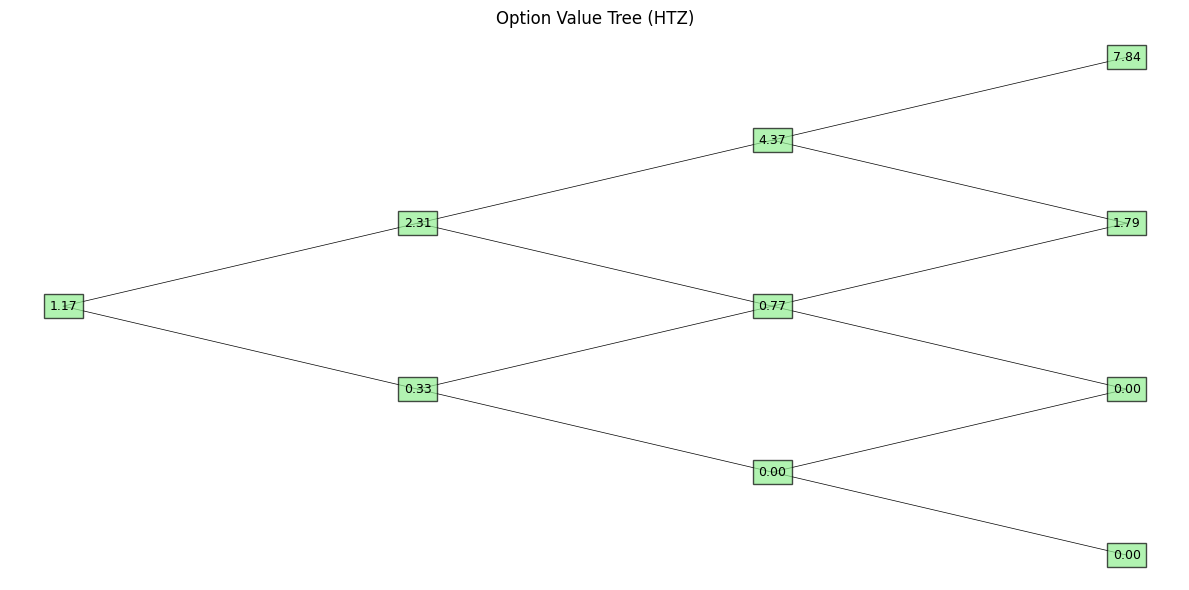

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Option Price: 1.1727 (using 1.9 years of historical data)


In [8]:
# Example: European Call option on HTZ
lookback_years = 1.9  # ✅ Number of years for the computation of the volatility σ.
                      #    Note that choosing a volatility is a prediction!
from datetime import datetime
end_date = datetime.today().strftime('%Y-%m-%d')

price, stock_tree, option_tree, delta_tree, bond_tree = binomial_model(
    payoff_func=call_payoff,
    ticker="HTZ",
    end_date=end_date,
    K=5.2,
    T=0.3,
    r=0.045,
    N=3,
    american=False,       # European
    plot_tree=True,
    lookback_years=lookback_years,
    show_strategy=True,   # <-- ΕΝΕΡΓΟΠΟΙΗΣΗ MathJax στρατηγικής
    return_trees=True     # <-- για να έχεις πρόσβαση στα δέντρα αν θέλεις
)

print(f"Option Price: {price:.4f} (using {lookback_years} years of historical data)")


## **Section 6. Example 2: American Put Option on AAPL**

Here we price an **American put** option on Apple Inc. (AAPL).  
Because it is American-style, early exercise is allowed.

[*********************100%***********************]  1 of 1 completed


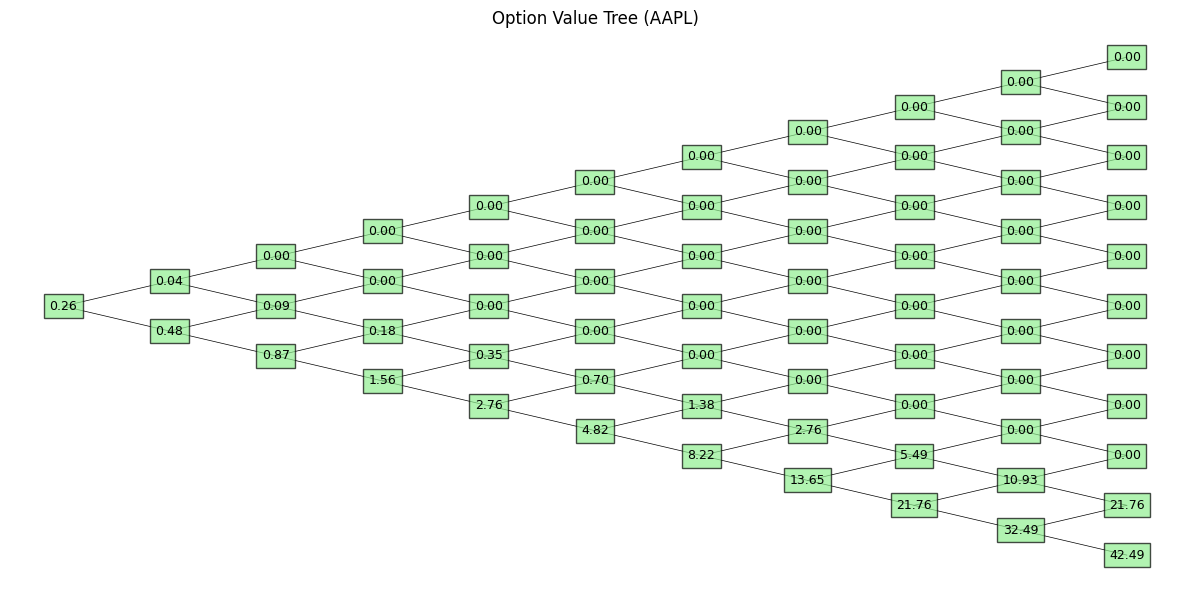

American Put Option (AAPL): 0.2638


In [9]:
def put_payoff(St, K):
    if isinstance(St, pd.Series):
        St = St.item()
    return np.maximum(K - St, 0)

price_aapl = binomial_model(
    payoff_func=put_payoff,
    ticker='AAPL',
    end_date=datetime.today().strftime('%Y-%m-%d'),
    K=180,
    T=0.5,
    r=0.04,
    N=10,
    american=True,
    plot_tree=True
)
print(f'American Put Option (AAPL): {price_aapl:.4f}')

## **Section 7. Example 3: Sensitivity Analysis**

We now examine how the option price changes as we vary key parameters:
- Volatility $\sigma$
- Risk-free rate $r$
- Number of time steps $N$

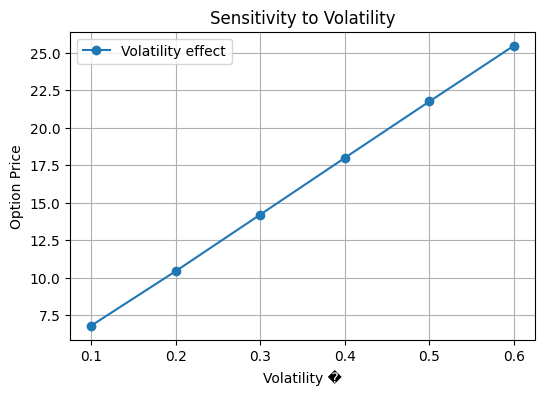

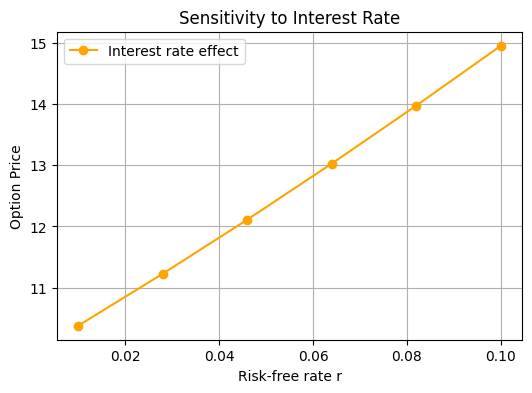

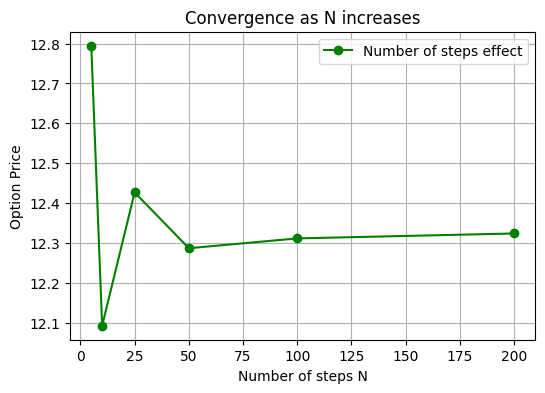

In [10]:
base_sigma = 0.25
sigma_values = np.linspace(0.1, 0.6, 6)
prices_sigma = []

for s in sigma_values:
    price = binomial_model(call_payoff, S0=100, K=100, T=1, r=0.05, sigma=s, N=100, american=False)
    prices_sigma.append(price)

plt.figure(figsize=(6,4))
plt.plot(sigma_values, prices_sigma, 'o-', label='Volatility effect')
plt.xlabel('Volatility �')
plt.ylabel('Option Price')
plt.title('Sensitivity to Volatility')
plt.legend()
plt.grid(True)
plt.show()

# Sensitivity to r
r_values = np.linspace(0.01, 0.1, 6)
prices_r = [binomial_model(call_payoff, S0=100, K=100, T=1, r=r, sigma=base_sigma, N=100, american=False) for r in r_values]
plt.figure(figsize=(6,4))
plt.plot(r_values, prices_r, 'o-', color='orange', label='Interest rate effect')
plt.xlabel('Risk-free rate r')
plt.ylabel('Option Price')
plt.title('Sensitivity to Interest Rate')
plt.legend()
plt.grid(True)
plt.show()

# Sensitivity to N
N_values = [5, 10, 25, 50, 100, 200]
prices_N = [binomial_model(call_payoff, S0=100, K=100, T=1, r=0.05, sigma=base_sigma, N=N, american=False) for N in N_values]
plt.figure(figsize=(6,4))
plt.plot(N_values, prices_N, 'o-', color='green', label='Number of steps effect')
plt.xlabel('Number of steps N')
plt.ylabel('Option Price')
plt.title('Convergence as N increases')
plt.legend()
plt.grid(True)
plt.show()

## **Section 8. Conclusions **

In this notebook we have implemented and explored the Binomial Option Pricing Model in detail.  

**Key takeaways:**
1. The binomial model converges to the Black-Scholes price as $N \to \infty$. Therefore any conclusion holds for the Black-Scholes model as well and any other stochastic model with parameters.
2. It naturally handles **American options**, which the closed-form Black-Scholes model cannot.
3. Volatility estimation is in fact a prediction, therefore different investors will choose different volatilities.

